# Import Libraries

In [51]:

# Standard Libraries
import pandas as pd
import numpy as np

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

import os
import json
import joblib

# Data Loading and Initial Exploration

In [52]:
os.chdir("C:/Users/USER/Desktop/GitHub/Nigeria-Housing-Price-Prediction")

In [53]:
# Load datasets
DATA_PATH_NIGERIA = os.getenv("DATA_PATH", default="dataset/nigeria_houses_data.csv")
nigeria_df = pd.read_csv(DATA_PATH_NIGERIA)

In [54]:
nigeria_df.info()
display(nigeria_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24326 entries, 0 to 24325
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bedrooms       24326 non-null  float64
 1   bathrooms      24326 non-null  float64
 2   toilets        24326 non-null  float64
 3   parking_space  24326 non-null  float64
 4   title          24326 non-null  object 
 5   town           24326 non-null  object 
 6   state          24326 non-null  object 
 7   price          24326 non-null  float64
dtypes: float64(5), object(3)
memory usage: 1.5+ MB


,bedrooms,bathrooms,toilets,parking_space,title,town,state,price
0,6.0,5.0,5.0,4.0,Detached Duplex,Mabushi,Abuja,450000000.0
1,4.0,5.0,5.0,4.0,Terraced Duplexes,Katampe,Abuja,800000000.0
2,4.0,5.0,5.0,4.0,Detached Duplex,Lekki,Lagos,120000000.0
3,4.0,4.0,5.0,6.0,Detached Duplex,Ajah,Lagos,40000000.0
4,4.0,4.0,5.0,2.0,Semi Detached Duplex,Lekki,Lagos,75000000.0


In [55]:
nigeria_df.shape

(24326, 8)

The dataset consists of 24,326 entries (rows) and 8 columns (features). This indicates that we have data for 24,326 properties across 8 features, which include both numeric and categorical attributes.

# Initial Observations and Data Understanding

In [56]:
nigeria_df.describe()

,bedrooms,bathrooms,toilets,parking_space,price
count,24326.000000,24326.000000,24326.000000,24326.000000,2.432600e+04
mean,4.338814,4.600798,5.176355,4.041725,3.013802e+08
std,1.138497,1.163161,1.226253,1.399936,1.220403e+10
min,1.000000,1.000000,1.000000,1.000000,9.000000e+04
25%,4.000000,4.000000,5.000000,4.000000,5.200000e+07
50%,4.000000,5.000000,5.000000,4.000000,8.500000e+07
75%,5.000000,5.000000,6.000000,4.000000,1.600000e+08
max,9.000000,9.000000,9.000000,9.000000,1.800000e+12


**Bedrooms, Bathrooms, Toilets, and Parking Space**

- The mean values indicate that most properties are moderately sized, with an average of 4-5 bedrooms, 4-5 bathrooms, 5 toilets, and 4 parking spaces.
- The maximum values (e.g., 9 bedrooms, 9 bathrooms, etc.) indicate that the dataset contains some large, luxury properties.

**Price**

- The mean price is around ₦301 million.
- The standard deviation is very high (₦12.2 billion), indicating that there is significant variation in property prices.
- The min value is ₦90 million, and the max value is a staggering ₦1.8 trillion, suggesting that there are both very affordable and extremely expensive properties.

In [57]:
nigeria_df.describe(include=['object'])

,title,town,state
count,24326,24326,24326
unique,7,189,25
top,Detached Duplex,Lekki,Lagos
freq,13992,10895,18445


**Title**

- There are 7 unique property types in the dataset, with 'Detached Duplex' being the most frequent (13,992 occurrences). This indicates that detached houses are the most common property type.

**Town**

- The dataset contains properties from 189 different towns. The most frequent town is Lekki with 10,895 occurrences, suggesting that Lekki is a popular area for real estate listings in Nigeria.

**State**

- There are 25 unique states, with Lagos being the most frequent (18,445 properties), indicating a strong real estate presence in Lagos.

In [58]:
print("Column Names:", nigeria_df.columns.tolist())

Column Names: ['bedrooms', 'bathrooms', 'toilets', 'parking_space', 'title', 'town', 'state', 'price']


#  Data Cleaning
- Addressing Datatypes
- Missing Values Analysis
- Duplicate Records
- Outliers Detection

## Addressing Datatypes

In [59]:
nigeria_df.dtypes


bedrooms         float64
bathrooms        float64
toilets          float64
parking_space    float64
title             object
town              object
state             object
price            float64
dtype: object

In [60]:
nigeria_df.head()

,bedrooms,bathrooms,toilets,parking_space,title,town,state,price
0,6.0,5.0,5.0,4.0,Detached Duplex,Mabushi,Abuja,450000000.0
1,4.0,5.0,5.0,4.0,Terraced Duplexes,Katampe,Abuja,800000000.0
2,4.0,5.0,5.0,4.0,Detached Duplex,Lekki,Lagos,120000000.0
3,4.0,4.0,5.0,6.0,Detached Duplex,Ajah,Lagos,40000000.0
4,4.0,4.0,5.0,2.0,Semi Detached Duplex,Lekki,Lagos,75000000.0


We can see that `bedrooms`, `bathrooms`, `toilets` and `parking_space` are all float datatypes instead of interger. We will need to address that.

In [61]:
# Convert specified columns from float to int
columns_to_convert = ['bedrooms', 'bathrooms', 'toilets', 'parking_space']
nigeria_df[columns_to_convert] = nigeria_df[columns_to_convert].astype('int64')

# Verify the conversion
print(nigeria_df[columns_to_convert].dtypes)



bedrooms         int64
bathrooms        int64
toilets          int64
parking_space    int64
dtype: object


## Missing Values Analysis

In [62]:
nigeria_df.isnull().sum()


bedrooms         0
bathrooms        0
toilets          0
parking_space    0
title            0
town             0
state            0
price            0
dtype: int64

we can see that there are no missing values

## Duplicate Records

In [63]:
nigeria_df.duplicated().sum()


10438

In [64]:
# Keep the first occurrence
nigeria_df = nigeria_df.drop_duplicates()

In [65]:
nigeria_df.shape

(13888, 8)

## Outlier Detection

In [66]:
nigeria_df.select_dtypes('number').skew()

bedrooms           0.303463
bathrooms          0.004096
toilets           -0.316401
parking_space      0.499450
price            102.064848
dtype: float64

The skewness values we’ve calculated for the numerical features show the following:

- bedrooms: 0.303 — Mild positive skew.
- bathrooms: 0.004 — Almost symmetric (negligible skew).
- toilets: -0.316 — Mild negative skew.
- parking_space: 0.499 — Moderate positive skew.
- price: 102.065 — Strong positive skew.

<Axes: xlabel='price'>

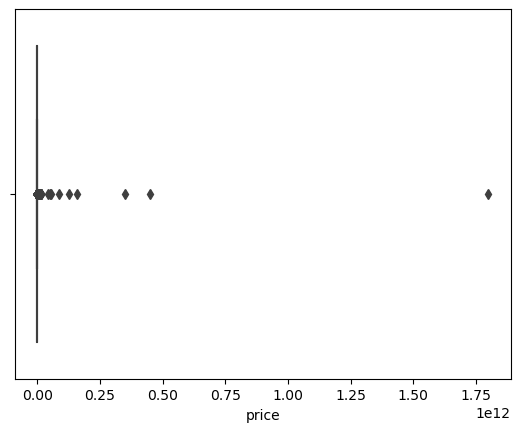

In [67]:
import seaborn as sns
sns.boxplot(x=nigeria_df['price'])


<Axes: >

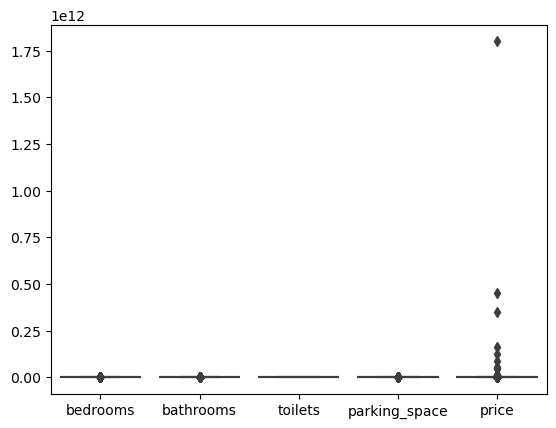

In [68]:
import seaborn as sns
sns.boxplot(data=nigeria_df[['bedrooms', 'bathrooms', 'toilets', 'parking_space', 'price']])


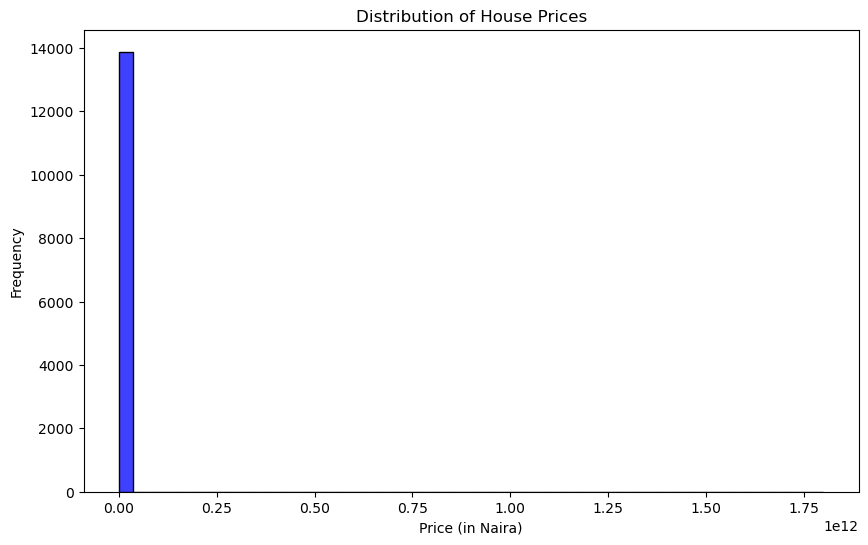

In [69]:
# Plotting the histogram for the 'price' column
plt.figure(figsize=(10, 6))
sns.histplot(nigeria_df['price'], kde=False, color='blue', bins=50)
plt.title('Distribution of House Prices')
plt.xlabel('Price (in Naira)')
plt.ylabel('Frequency')
plt.show()


From the above Outlier detection and also confirming with Visualization method we can wee that only `price` feature is heavily right skewed. we will need to address this. 

In [70]:
# Apply log transformation to the 'price' feature
nigeria_df['price'] = np.log1p(nigeria_df['price'])
nigeria_df.select_dtypes('number').skew()

bedrooms         0.303463
bathrooms        0.004096
toilets         -0.316401
parking_space    0.499450
price            0.373771
dtype: float64

# Exploratory Data Analysis (EDA)

# Data Preprocessing and Feature Engineering

# Data Splitting

# Model Development and Training

# Model Evaluation

# Model Interpretation and Feature Importance

# Saving and Deploying the Model

# 